<a href="https://colab.research.google.com/github/matheus97eng/Bootcamp_Alura_2021/blob/main/modulo-3/aulas/notebooks/aula_3_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 4

Essa aula faz parte do módulo 3 sobre séries temporais do bootcamp de DataSciance aplicada da Alura. Aqui vamos trabalhar com o fbprophet tratando feriados e sazonalidades. Os dados trabalhados durante todo o módulo serão dados públicos do [governo de São Paulo](https://www.seade.gov.br/coronavirus/) sobre os **casos de corona vírus**. Os dados já foram retirados do site e disponibilizados pelo github da Alura no dia 18/05/2021, [neste repositório](https://github.com/alura-cursos/Prophet_covid/blob/main/dados_covid_sp.zip).

Os dados usados nesta aula são somente da cidade de São Paulo, [deste repositório](https://github.com/matheus97eng/Bootcamp_Alura_2021/blob/main/modulo-3/aulas/data/out_dados_sp.csv).

## Preparando o ambiente

In [ ]:
# obtendo os dados

import pandas as pd

url = 'https://github.com/matheus97eng/Bootcamp_Alura_2021/raw/main/modulo-3/aulas/data/out_dados_sp.csv'
dados_sp = pd.read_csv(url, index_col=0)
dados_sp.head()

,index,nome_munic,codigo_ibge,dia,mes,datahora,casos,casos_novos,casos_pc,casos_mm7d,obitos,obitos_novos,obitos_pc,obitos_mm7d,letalidade,nome_ra,cod_ra,nome_drs,cod_drs,pop,pop_60,area,map_leg,map_leg_s,latitude,longitude,semana_epidem,taxa_de_crescimento_casos,taxa_de_crescimento_obitos,ano,media_movel_casos,media_movel_obitos
0,562,São Paulo,3550308,25,2,2020-02-25,1,0,"8,424841e-03","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,<50,7.0,"-23,5329","-46,6395",9,NaN,NaN,2020,NaN,NaN
1,1207,São Paulo,3550308,26,2,2020-02-26,1,0,"8,424841e-03","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,<50,7.0,"-23,5329","-46,6395",9,0.0,0.0,2020,NaN,NaN
2,1852,São Paulo,3550308,27,2,2020-02-27,1,0,"8,424841e-03","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,<50,7.0,"-23,5329","-46,6395",9,0.0,0.0,2020,NaN,NaN
3,2497,São Paulo,3550308,28,2,2020-02-28,2,1,"1,684968e-02","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,<50,7.0,"-23,5329","-46,6395",9,1.0,0.0,2020,NaN,NaN
4,3142,São Paulo,3550308,29,2,2020-02-29,2,0,"1,684968e-02","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,<50,7.0,"-23,5329","-46,6395",9,-1.0,0.0,2020,NaN,NaN


In [ ]:
# vamos retirar a coluna "index":

dados_sp.drop('index', axis=1, inplace=True)

In [ ]:
# convertendo a coluna "datahora" em um time series:

dados_sp['datahora'] = pd.to_datetime(dados_sp['datahora'], format='%Y-%m-%d')
dados_sp['datahora']

0     2020-02-25
1     2020-02-26
2     2020-02-27
3     2020-02-28
4     2020-02-29
         ...    
438   2021-05-08
439   2021-05-09
440   2021-05-10
441   2021-05-11
442   2021-05-12
Name: datahora, Length: 443, dtype: datetime64[ns]

### Funções úteis

Muitos comandos serão repetidos durante as aulas, por isso vamos criar funções para economizar linhas de código:

+ `split_test_train` separa os dataframes df_train e df_test de acordo com 2 parâmetros, period, que conta quantos dias deixaremos para realizar o teste, e percent_test, recebe a porcentagem dos dados que queremos deixar para teste. Só é necessário informar um desses parâmetros. Se for informado a porcentagem, o período não será levado em conta.

+ `make_prediction` recebe um modelo instanciado do fbprophet, além dos dataframes de teste e treino. Ele faz o fit do modelo e e retorna o daframe de previsão (`forecast`) de acordo com os dias que foram passados para o dataframe de teste.

In [ ]:
from fbprophet import Prophet

def split_train_test(data, ds='datahora', y='casos_novos', period=30, percent_test=None):

  df_test = pd.DataFrame()
  df_train = pd.DataFrame()
  
  if percent_test == None:
    x = data.shape[0] - period
  else:
    x = int(data.shape[0] * (1-percent_test))

  df_train['ds'] = data[ds][:x]
  df_train['y'] = data[y][:x]
  df_test['ds'] = data[ds][x:]
  df_test['y'] = data[y][x:]

  return df_train, df_test

def make_prediction(model, df_train, df_test, cap=None):

  model.fit(df_train)
  df_future = model.make_future_dataframe(periods=df_test.shape[0])
  if cap != None:
    df_future['cap'] = cap
  forecast = model.predict(df_future)
  return forecast

## COMEÇANDO AS ANÁLISES

Como foi visto desde a aula 1, os dados do número de casos e óbitos por covid apresentam uma sazonalidade semanal. Com o gráfico da [aula 1] é possível ver bem isso:

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

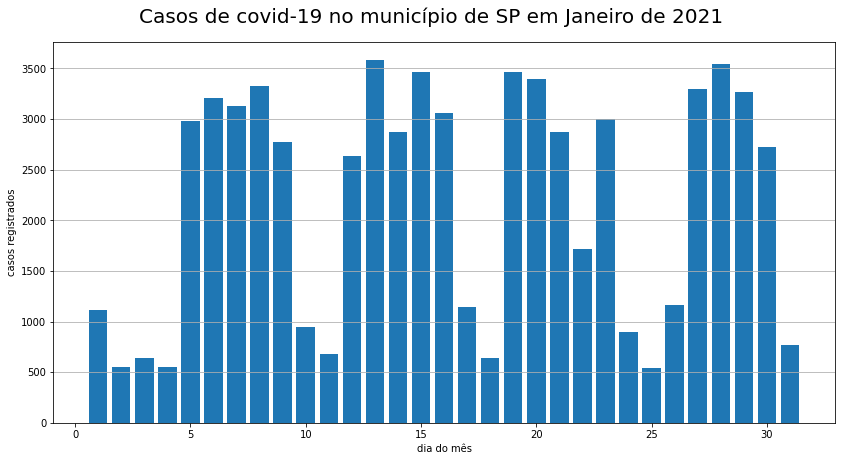

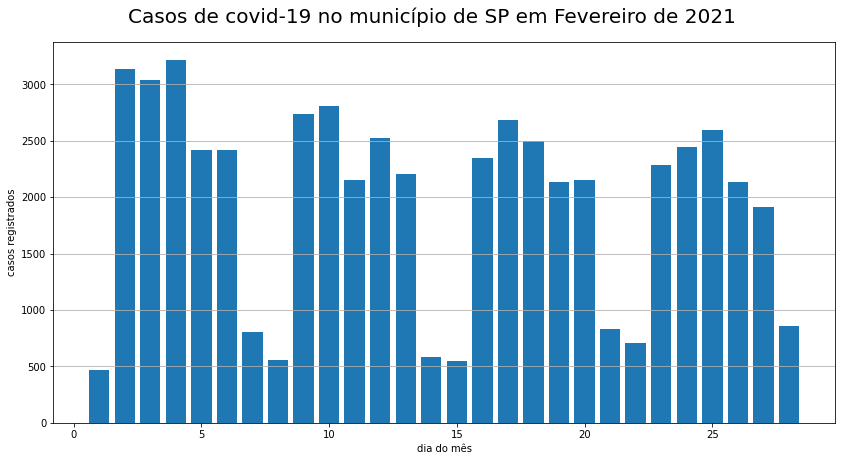

In [ ]:
mpl.rcParams['figure.figsize'] = (14,7)

# janeiro tem um espaço de 31 dias:
dados_sp_01_2021 = dados_sp.query('ano == 2021 and mes == 1')

plt.bar(np.linspace(1,31,31), dados_sp_01_2021['casos_novos'])
plt.suptitle('Casos de covid-19 no município de SP em Janeiro de 2021', size=20, y=0.95)
plt.ylabel('casos registrados')
plt.xlabel('dia do mês')
plt.grid(axis='y')
plt.show()    # forçando o python a plotar esse gráfico

# já fevereiro tem um espaço de 28 dias em 2021:
dados_sp_02_2021 = dados_sp.query('ano == 2021 and mes == 2')

plt.bar(np.linspace(1,28,28), dados_sp_02_2021['casos_novos'])
plt.suptitle('Casos de covid-19 no município de SP em Fevereiro de 2021', size=20, y=0.95)
plt.ylabel('casos registrados')
plt.xlabel('dia do mês')
plt.grid(axis='y')
plt.show()

Além de apresentar uma baixa nos casos nos dias de domingo e segunda, parece haver também baixas nos dias seguintes de feriados. Vale lembrar que o registro do dia se refere ao número de casos do dia **anterior** ([ver notas sobre os dados](https://www.seade.gov.br/wp-content/uploads/2021/06/Boletim-Coronavirus-Anexo-metodologico.pdf)).

Há uma funcionalidade do fbprophet que inclui feriados nas análises. Como cada país tem seu calendário de feriados, precisamos dos registros do Brasil. Por sorte temos todos eles registrados no fbprophet.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


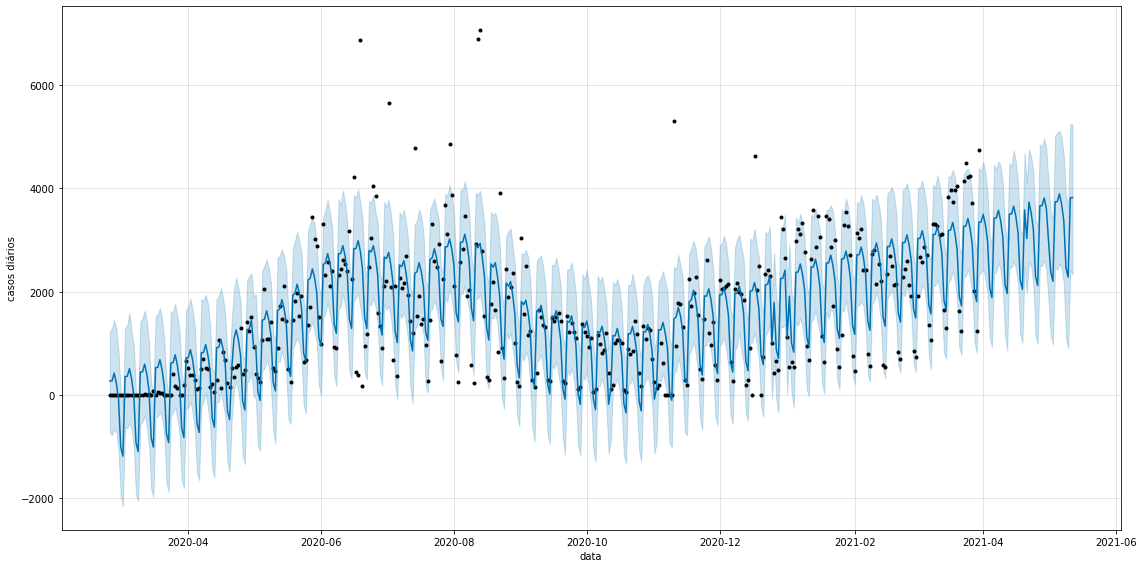

In [ ]:
modelo = Prophet(changepoint_prior_scale=10)
modelo.add_country_holidays(country_name='BR')

# a partir daqui podemos usar as funções definidas anteriormente

df_train, df_test = split_train_test(dados_sp, period=43)
forecast = make_prediction(modelo, df_train, df_test)

fig = modelo.plot(forecast, xlabel='data', ylabel='casos diários', figsize=(16,8))

A diferença que temos no modelo agora é que ele não considera somente a sazonalidade semanal para produzir a curva ajustada pelo modelo, mas também feriados, onde sabemos que há quedas nos dados de casos de covid. Podemos observar essas quedas no gráfico acima.

Mas nós sabemos que o Brasil é um país muito diversificado e cada cidade sua possui feriados específicos daquela região. Além disso, São Paulo, assim como muitas cidades, antecipou feriados por conta da própria pandemia. Isso deve ser levado em conta quando estudamos o caso específico dessa cidade. Por isso foi preparada uma lista python contendo todos os feriados que ocorreram em SP em 2020 e 2021:

In [ ]:
feriados_sp_2020= [
'2020-02-25',
'2020-02-26',
'2020-04-10',
'2020-04-21',
'2020-05-01',
'2020-05-20',
'2020-05-21',
'2020-05-22',
'2020-05-25',
'2020-06-11',
'2020-09-07',
'2020-10-12',
'2020-11-02',
'2020-11-15',
'2020-12-25'
]

feriados_sp_2021= [
'2020-01-01',
'2020-01-25',
'2020-02-15',
'2020-02-16',
'2020-02-17',
'2020-03-26',
'2020-03-29',
'2020-03-30',
'2020-03-31',
'2020-04-01',
'2020-04-02',
'2020-4-21',
'2020-05-01'
]

Lembrando que as datas precisam estar no formato datetime para serem reconhecidas pelo fbprophet. Essa ferramenta nos permite adicionar ao modelo os feriados que quisermos, mas precisamos preparar essas informações em um dataframe próprio para o prophet lidar.

In [ ]:
feriados_2020 = pd.DataFrame({'holiday':'sp_2020', 'ds':pd.to_datetime(feriados_sp_2020)})
feriados_2021 = pd.DataFrame({'holiday':'sp_2021', 'ds':pd.to_datetime(feriados_sp_2021)})

feriados = pd.concat((feriados_2020, feriados_2021))
feriados.head()

,holiday,ds
0,sp_2020,2020-02-25
1,sp_2020,2020-02-26
2,sp_2020,2020-04-10
3,sp_2020,2020-04-21
4,sp_2020,2020-05-01


agora sim podemos definir o modelo:

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


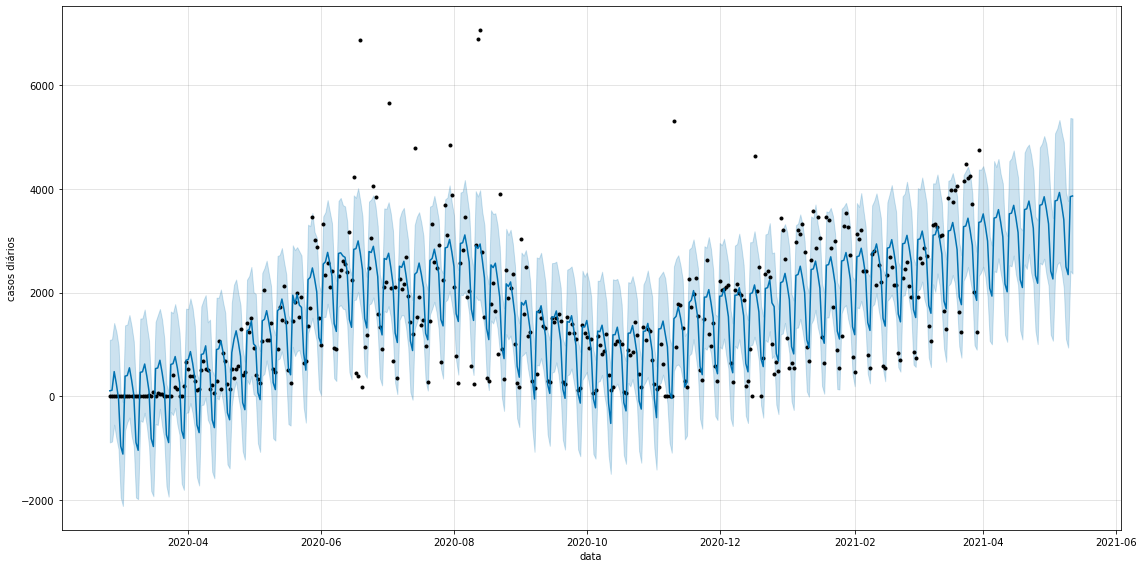

In [ ]:
modelo_feriados = Prophet(changepoint_prior_scale=10, holidays=feriados)

df_train, df_test = split_train_test(dados_sp, period=43)
forecast = make_prediction(modelo_feriados, df_train, df_test)

fig = modelo_feriados.plot(forecast, xlabel='data', ylabel='casos diários', figsize=(16,8))

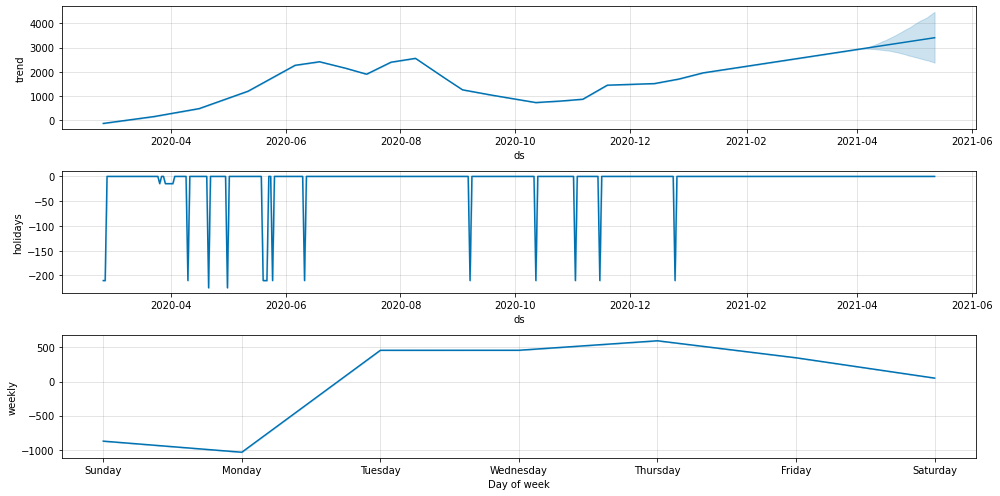

In [ ]:
# visualizando os feriados incluídos

modelo_feriados.plot_components(forecast, figsize=(14,7));

## Tipos de sazonalidade e métricas

Existem diferentes tipos de sazonalidade. A que o fbprophet trabalha por padrão é a aditiva. Queremos ver a diferença de um modelo que considera a sazonalidade sendo multiplicativa. Mas para isso vamos utilizar métricas avaliativas do método que estamos utilizando. Uma delas é o erro médio absoluto, que basicamente faz o módulo das diferenças entre o valores reais e os calculados, fazendo ao final o somatório desses módulos. Essa métrica está disponível na biblioteca sklearn.

In [ ]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(df_train['y'], forecast['yhat'][:400])    # os 2 dataframes devem possuir o mesmo número de linhas

538.0474179988163

Agora vamos mudar a opção do nosso modelo indicando que a sazonalidade da nossa série é do tipo multiplicativa

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


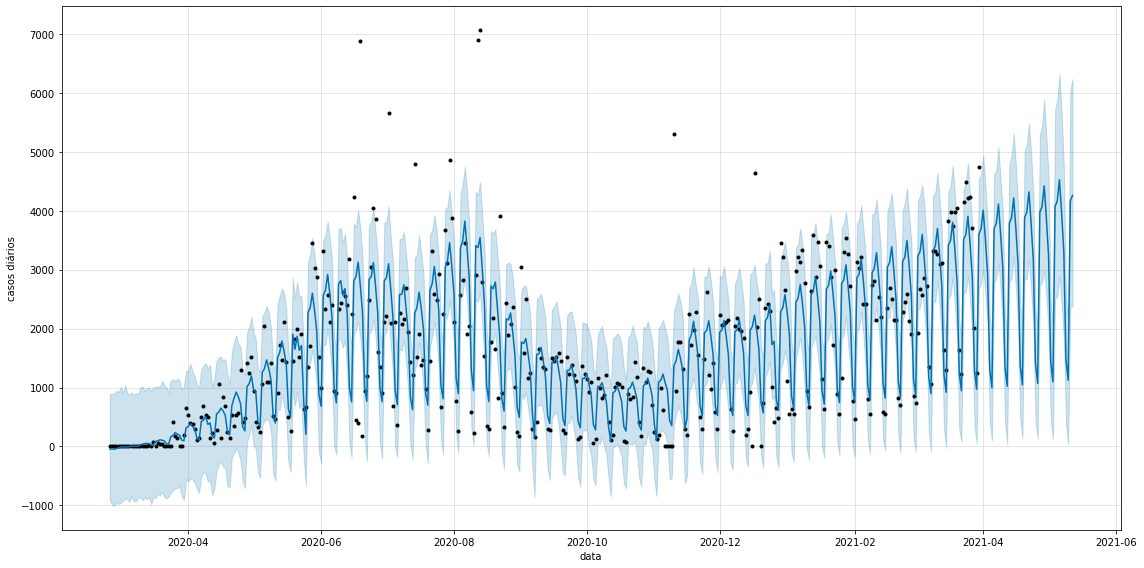

In [ ]:
modelo_feriados = Prophet(changepoint_prior_scale=10, holidays=feriados, seasonality_mode='multiplicative')

df_train, df_test = split_train_test(dados_sp, period=43)
forecast = make_prediction(modelo_feriados, df_train, df_test)

fig = modelo_feriados.plot(forecast, xlabel='data', ylabel='casos diários', figsize=(16,8))

Agora percebemos que o gráfico ficou bastante diferente, principalmente no início. Percebemos que a amplitude entre o menor e o maior número de casos registrados na semana vai mudando ao longo do tempo, o que representa melhor a realidade do nosso caso. Na sazonalidade aditiva, não observamos essa mudança de amplitude.

Agora, se usarmos a mesma métrica do erro médio absoluto, verificaremos que o modelo de sazonalidade multiplicativa é melhor:



In [ ]:
mean_absolute_error(df_train['y'], forecast['yhat'][:400])

452.2884903942229

## Corrigindo a lista dos feriados

Como foi falado anteriormente, os registros dos casos são considerados do dia anterior. Seguindo essa lógica, a lista de feriados deveria conter os dias após as verdadeiras datas dos feriados. Vamos fazer isso e verificar se o erro médio absoluto diminui comparado ao modelo que usa a outra lista de feriados.

In [ ]:
# e se considerassemos o dia seguinte ao feriado?

import datetime

lista_2020 = [(datetime.datetime.strptime(date, '%Y-%m-%d') + datetime.timedelta(days=1)) for date in feriados_sp_2020]
lista_2021 = [(datetime.datetime.strptime(date, '%Y-%m-%d') + datetime.timedelta(days=1)) for date in feriados_sp_2021]
feriados_2020 = pd.DataFrame({'holiday':'sp_2020', 'ds':pd.to_datetime(lista_2020)})
feriados_2021 = pd.DataFrame({'holiday':'sp_2021', 'ds':pd.to_datetime(lista_2021)})

feriados_corrigidos = pd.concat((feriados_2020, feriados_2021))
feriados_corrigidos.head()

,holiday,ds
0,sp_2020,2020-02-26
1,sp_2020,2020-02-27
2,sp_2020,2020-04-11
3,sp_2020,2020-04-22
4,sp_2020,2020-05-02


In [ ]:
modelo_feriados = Prophet(changepoint_prior_scale=10, holidays=feriados_corrigidos, seasonality_mode='multiplicative')

df_train, df_test = split_train_test(dados_sp, period=43)
forecast = make_prediction(modelo_feriados, df_train, df_test)
mean_absolute_error(df_train['y'], forecast['yhat'][:400])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


449.31692526206496

realmente foi verificado que alterar as datas dos feriados para um dia após fez efeito no modelo, melhorando ele.

In [ ]:
# exportando o dataframe feriados_corrigidos para utilizar na próxima aula:

feriados_corrigidos.to_csv('out_feriados_corrigidos.csv')

## Desafios:

Desafio Extra: Utilizar outras métricas do Scikitlearn e comparar os resultados.

Desafio Extra 2: tornar os pontos pretos em uma linha, para comparar com a curva ajustada

### Desafio Extra: Utilizar outras métricas do Scikitlearn e comparar os resultados.

A biblioteca sklearn possui mais diversas maneiras de se calcular a acurácia de um modelo. Vamos testar algumas delas. Lembrando que o último modelo rodado foi considerando **a sazonalidade multiplicativa e o ajuste na lista de feriados**.

#### [Erro quadrático médio](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error)

Calcula o quadrado da diferença entre o valor real e o valor calculado pelo modelo. Ao final os quadrados são somados e divididos pelo número de amostras.

Como a diferença é elevada ao quadrado, a unidade de medida do erro também deverá ser dada ao quadro. No nosso caso, o valor seria contado em número de casos ao quadrado, o que não faz sentido. Mas a função `mean_squared_error` possui a funcionalidade de extrair a raíz desse valor, o que faz a unidade de medida do erro voltar a ser número de casos. Para fazer isso, colocamos o parâmetro `squared=False`.

Também por conta das diferenças serem elevadas ao quadrado, o erro quadrático médio é mais sensível a valores discrepantes, possíveis candidatos a outliers.

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(df_train['y'], forecast['yhat'][:400], squared=False)

718.6344826060398

Esse erro medido foi maior do que o erro médio absoluto, o que pode indicar que os dados que temos de casos possuem uma quantidade significativa de valores discrepantes.

### Desafio Extra 2: tornar os pontos pretos em uma linha, para comparar com a curva ajustada

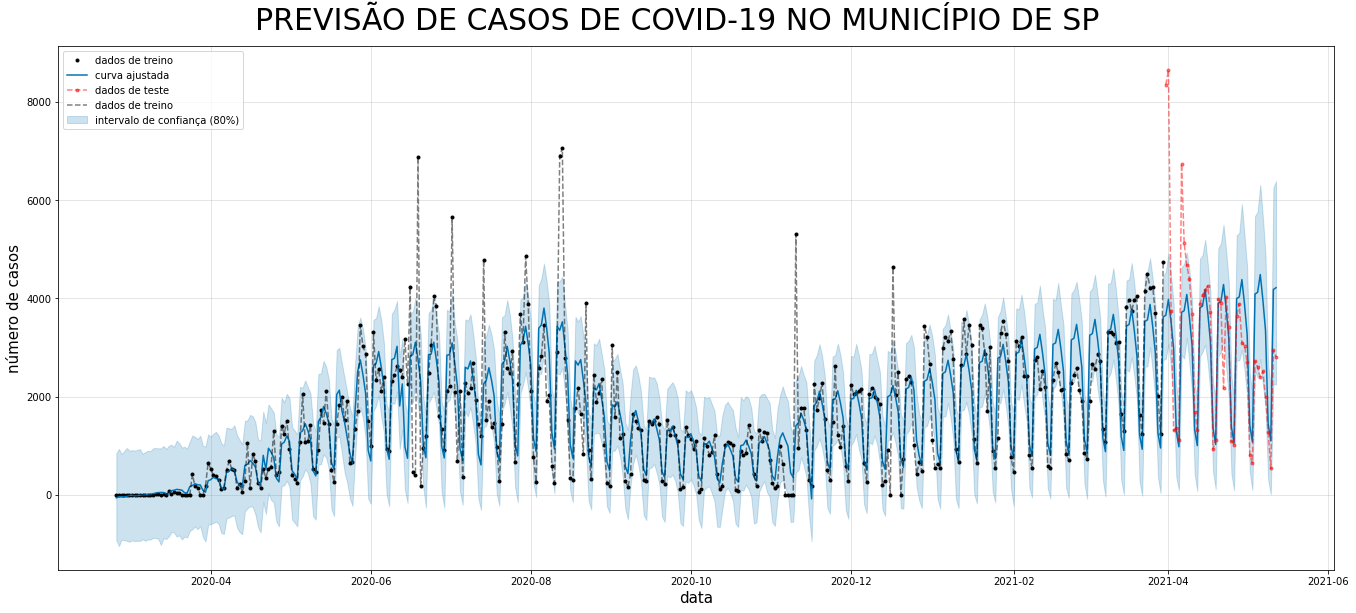

In [ ]:
fig = modelo_feriados.plot(forecast, figsize=(19,8))       # gráfico do fbprophet 
plt.plot(df_test['ds'], df_test['y'], linestyle='--', 
         marker='.', color='red', alpha=0.5)                # pontos e curva dos dados de teste
plt.plot(df_train['ds'], df_train['y'], linestyle='--',
         color = 'black', alpha=0.5)                        # curva dos dados de treino

plt.xlabel('data', size=15)
plt.ylabel('número de casos', size=15)
plt.legend(['dados de treino', 'curva ajustada', 'dados de teste', 'dados de treino', 'intervalo de confiança (80%)'])
plt.suptitle("previsão de casos de covid-19 no município de SP".upper(), size=30, y=1.05)
plt.show()